# Awkward to RDataFrame and back

[Awkward Array](https://github.com/scikit-hep/awkward) is a library for nested, variable-sized data, including arbitrary-length lists, records, mixed types, and missing data, using NumPy-like idioms. It is a cornerstone of user analyses in Python eco-system.

RDataFrame - ROOT's declarative analysis interface that supports many input formats. Awkward Arrays and RDataFrame are two very different ways of performing calculations at scale.

There are numerous benefits of the combining both Python and C++. Physicists can mix analyses using Awkward Arrays, Numba, and ROOT C++ in memory, without saving to disk and without leaving their environment.

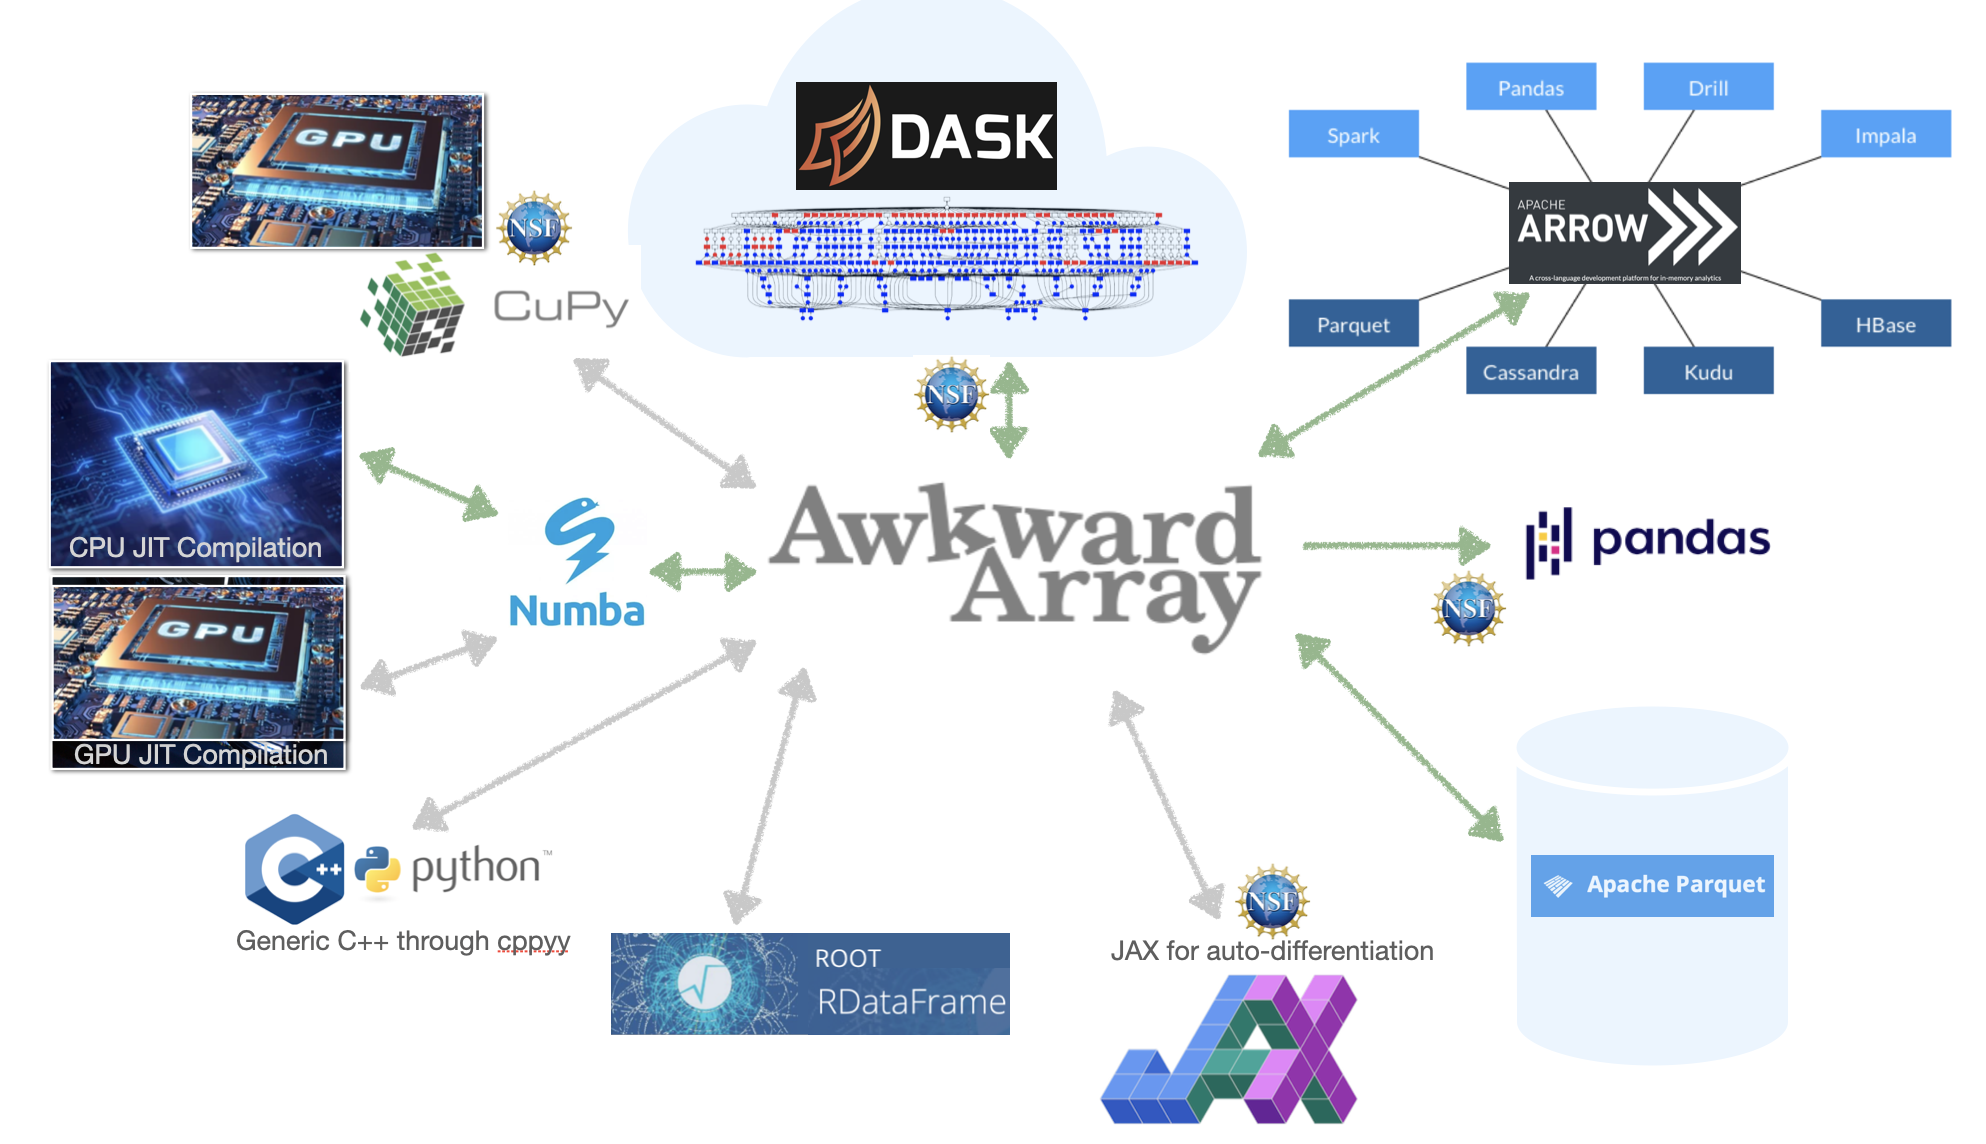
Let's focus on Awkward to RDataFrame and back.

## From Awkward Arrays to RDataFrame

In [1]:
import awkward._v2 as ak
import ROOT

Welcome to JupyROOT 6.26/02


Let’s start from Awkward Arrays to RDataFrame direction. Let’s look at the Array Views.

The awkward style *to_rdataframe* function presents a view of an Awkward Array as an RDataFrame source:

* Awkward Arrays are already JIT-compiled with Numba.
    * Here we are reusing some of the Numba implementation for C++.
    * This code is well tested and profiled - no performance difference.

This Array view is generated on demand and the data is not copied - we do not know the view type at compile time. 
RDF source needs the pointer to the data and also needs to know the data type. This is per column. 
Hence the column readers are generated based on the run-time type of the views. The readers are passed to a generated source derived from ROOT::RDF::RDataSource.

In [2]:
array_x = ak.Array(
        [
            {"x": [1.1, 1.2, 1.3]},
            {"x": [2.1, 2.21]},
            {"x": [3.1]},
            {"x": [4.1, 4.2, 4.3, 4.4]},
            {"x": [5.1]},
        ]
    )
array_y = ak.Array([1, 2, 3, 4, 5])
array_z = ak.Array([1.1, 2.2, 3.3, 4.4, 5.5])


df = ak.to_rdataframe({"x": array_x, "y": array_y, "z": array_z})

In [3]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  ULong64_t                       Define
x               awkward::Record_b42WdtjLqYU     Dataset
y               int64_t                         Dataset
z               double                          Dataset

In [4]:
df.GetColumnType("x")

'awkward::Record_b42WdtjLqYU'

In [5]:
df.GetColumnType("y")

'int64_t'

In [6]:
df.GetColumnType("z")

'double'

In [7]:
df.Count().GetValue()

5

In [8]:
df = df.Filter("y > 2")

In [9]:
out = ak.from_rdataframe(
    df,
    columns=("x", "y", "z", "awkward_index_"),
)

In [10]:
out

<Array [{x: {...}, y: 3, z: 3.3, ...}, ...] type='3 * {x: {x: var * float64...'>

In [11]:
print(out.layout.form)

{
    "class": "RecordArray",
    "contents": {
        "x": {
            "class": "IndexedArray",
            "index": "i64",
            "content": {
                "class": "RecordArray",
                "contents": {
                    "x": {
                        "class": "ListArray",
                        "starts": "i64",
                        "stops": "i64",
                        "content": "float64"
                    }
                }
            }
        },
        "y": "int64",
        "z": "float64",
        "awkward_index_": "uint64"
    }
}


In [12]:
print(out["y"].to_list())
print(out["z"].to_list())
print(out["awkward_index_"].to_list())
print(out["x"].to_list())

[3, 4, 5]
[3.3, 4.4, 5.5]
[2, 3, 4]
[{'x': [3.1]}, {'x': [4.1, 4.2, 4.3, 4.4]}, {'x': [5.1]}]


In [13]:
df.Count().GetValue()

3

## From RDataFrame to Awkward Arrays

The *ak.from_rdataframe* function converts selected columns to native Awkward Arrays.

The conversion of the data taken out of the RDF is limited to:

* Primitive types: `integer`, `float`, `double`, `std::complex<double>`, etc.
* Lists of primitive types and the arbitrary depth nested lists of primitive types: `std::vector<double>`, `RVec<int>`, etc.
* Awkward types: run-time generated types derived from `awkward::ArrayView` or `awkward::RecordView`
  * because Awkward Arrays are immutable no copy required

In [14]:
import awkward._v2 as ak
import matplotlib
import matplotlib.pyplot as plt
import ROOT

In [15]:
# CMS data from CERN Open Data portal: http://opendata.web.cern.ch/record/12341.
# Create a dataframe
df = ROOT.RDataFrame('Events', 'Run2012BC_DoubleMuParked_Muons.root')

In [16]:
# Describe the state of the dataframe.
# Note that this operation is not running the event loop.
# Describe returns a DFDescription object, which has e.g. a Print method. See its docs for more information.
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            6
Columns from defines        0
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [17]:
# Build a small analysis studying the invariant mass of dimuon systems.
# See tutorial df102_NanoAODDimuonAnalysis for more information:
# https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html
df = df.Filter('nMuon == 2')\
        .Filter('Muon_charge[0] != Muon_charge[1]')\
        .Define('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
        .Filter('Dimuon_mass > 70')\
        .Range(1000)

In [18]:
# Trigger the event loop by asking for the mean of the dimuon mass.
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



In [19]:
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [20]:
# Convert selected columns to Awkward array.
array = ak.from_rdataframe(
        df,                #     Type                            Origin
        columns=(          #     ----                            ------
            "Dimuon_mass", #     float                           Define
            "Muon_charge", #     ROOT::VecOps::RVec<Int_t>       Dataset
            "Muon_eta",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_mass",   #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_phi",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_pt",     #     ROOT::VecOps::RVec<Float_t>     Dataset
            "nMuon",       #     UInt_t                          Dataset
        ),
    )

In [21]:
array

<Array [{Dimuon_mass: 114, ...}, ..., {...}] type='1000 * {Dimuon_mass: flo...'>

In [22]:
# Check the array structure.
print(array.layout.form)

{
    "class": "RecordArray",
    "contents": {
        "Dimuon_mass": "float32",
        "Muon_charge": {
            "class": "ListOffsetArray",
            "offsets": "i64",
            "content": "int32"
        },
        "Muon_eta": {
            "class": "ListOffsetArray",
            "offsets": "i64",
            "content": "float32"
        },
        "Muon_mass": {
            "class": "ListOffsetArray",
            "offsets": "i64",
            "content": "float32"
        },
        "Muon_phi": {
            "class": "ListOffsetArray",
            "offsets": "i64",
            "content": "float32"
        },
        "Muon_pt": {
            "class": "ListOffsetArray",
            "offsets": "i64",
            "content": "float32"
        },
        "nMuon": "uint32"
    }
}


In [23]:
# Check that all the columns were retrieved in a single event loop.
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             2
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

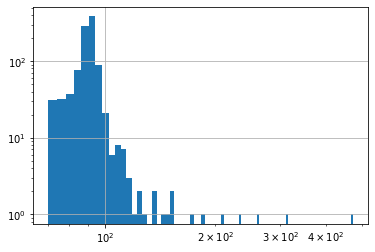

In [24]:
plt.hist(array["Dimuon_mass"], bins=100)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)